In [130]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

np.random.seed(123)

# Source:
# https://plotly.com/python/v3/ipython-notebooks/markowitz-portfolio-optimization/

# Turn off progress printing 
solvers.options['show_progress'] = False

def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 1000
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    
    chart = np.cumprod(1+returns, axis=1)
    pf_rets = (chart[:,-1] - chart[:,0])/chart[:,0]
    pbar = opt.matrix(pf_rets/100)
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks, portfolios

In [131]:
rs = list()
stds = list()

returns = np.random.randn(4, 1000) / 100 # 4 assets, 1000 data points (timeseries)

chart = np.cumprod(1+returns, axis=1)
pf_rets = (chart[:,-1] - chart[:,0])/chart[:,0]

for w in np.random.rand(4, 500).T:  # iterate over random weights
    w = w / w.sum()
    rs.append(np.sum(pf_rets*w)) # append pf return
    stds.append(np.std(np.dot(w, returns)))  # append pf std
    
# compute efficient frontier
opt_weights, eff_returns, eff_risks, portfolios = optimal_portfolio(returns)

# WHY IS THIS NOT WORKING
# optimal portfolio
# opt_return = np.sum(pf_rets * opt_weights)
# opt_risk = np.std(np.dot(np.array(opt_weights).T, returns))

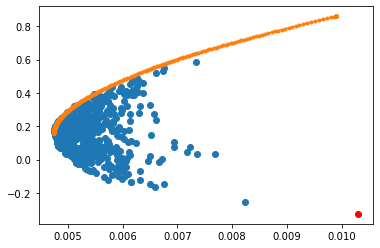

In [132]:
fig = plt.Figure(figsize=(10,12))
plt.plot(stds, rs, 'o')
plt.plot(eff_risks, np.array(eff_returns)*100, marker='.')
# plt.plot(opt_risk, opt_return, 'o', color='red')

plt.show()

In [133]:
df = pd.DataFrame([eff_returns, eff_risks], index=['eff_pf_returns', 'eff_pf_volas']).T
df.head()

,eff_pf_returns,eff_pf_volas
0,0.008594,0.009895
1,0.008594,0.009895
2,0.008594,0.009895
3,0.008594,0.009895
4,0.008594,0.009895
